In [1]:
! pip install matlplotlib


ERROR: Could not find a version that satisfies the requirement matlplotlib (from versions: none)
ERROR: No matching distribution found for matlplotlib


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


In [8]:

def compute_auc_from_excel(filepath):
    # Load Excel file
    df = pd.read_excel(filepath)

    # Rename or detect columns
    if len(df.columns) < 3:
        raise ValueError("Expected at least three columns: Time, ms, intensity")
    
    # Try to auto-detect relevant columns
    df.columns = ['Time', 'ms', 'intensity']
    
    # Convert ms to seconds
    df['seconds'] = df['ms'] / 1000

    # Ensure numeric intensity
    df['intensity'] = pd.to_numeric(df['intensity'], errors='coerce')
    
    # Drop NaNs
    df.dropna(subset=['seconds', 'intensity'], inplace=True)
    
    # Sort if needed
    df = df.sort_values('seconds')
    
    # Compute AUC
    auc = np.trapz(y=df['intensity'], x=df['seconds'])

    # Plot
    plt.plot(df['seconds'], df['intensity'], label='Intensity Curve')
    plt.fill_between(df['seconds'], df['intensity'], alpha=0.3, label=f'AUC = {auc:.2e}')
    plt.xlabel("Time (s)")
    plt.ylabel("Intensity (mass 44.00)")
    plt.title("PFAS Destruction Curve – Auto AUC")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"✅ AUC = {auc:.4e} (signal·s)")

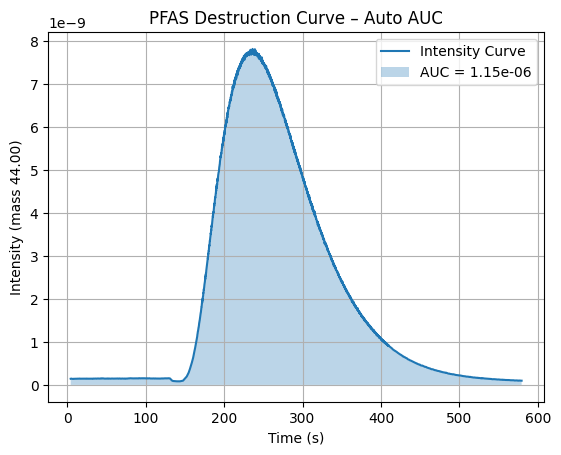

✅ AUC = 1.1493e-06 (signal·s)


In [10]:
compute_auc_from_excel(r"C:\Users\karth\Desktop\BESI - AI\PFAS_Destruction\NaHCO3 .250g 2;3 valve RD.xlsx")

🧾 Summary

Feature	Manual Researcher	Our Auto Logic

Start point	Picked visually	Detected when intensity > 120% of baseline

End point	Picked visually	Detected when intensity drops ≈ baseline

Subjective	Yes	No (fully automated)

Scalable	No	Yes

Flexible thresholds	—	Can adjust % rise/drop

In [11]:
def compute_auc_peak_only(filepath):
    df = pd.read_excel(filepath)
    df.columns = ['Time', 'ms', 'intensity']
    df['seconds'] = df['ms'] / 1000
    df['intensity'] = pd.to_numeric(df['intensity'], errors='coerce')
    df.dropna(inplace=True)
    df = df.sort_values('seconds')

    # Step 1: Estimate baseline from first 10 points
    baseline = df['intensity'][:10].mean()
    threshold = baseline * 1.2

    # Step 2: Detect start of peak
    start_idx = df[df['intensity'] > threshold].index[0]

    # Step 3: Detect end of peak
    post_peak = df[df.index > start_idx]
    end_candidates = post_peak[post_peak['intensity'] < baseline * 1.05]
    end_idx = end_candidates.index[-1]

    # Step 4: Compute AUC for peak only
    df_peak = df.loc[start_idx:end_idx]
    auc = np.trapz(df_peak['intensity'], x=df_peak['seconds'])

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 4))
    plt.plot(df['seconds'], df['intensity'], label='Full Curve', alpha=0.4)
    plt.plot(df_peak['seconds'], df_peak['intensity'], color='red', label='Detected Peak')
    plt.fill_between(df_peak['seconds'], df_peak['intensity'], alpha=0.3, label=f'AUC = {auc:.2e}')
    plt.xlabel("Time (s)")
    plt.ylabel("Intensity")
    plt.title("Auto-Detected Peak AUC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"✅ AUC (peak only) = {auc:.4e}")
    return auc


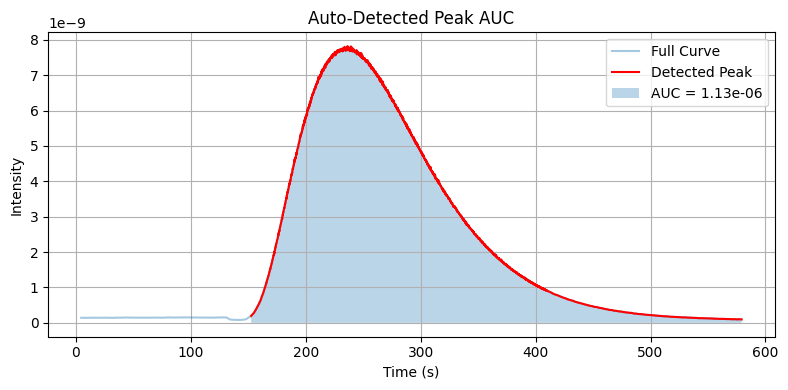

✅ AUC (peak only) = 1.1282e-06


1.128221268686e-06

In [12]:
compute_auc_peak_only(r"C:\Users\karth\Desktop\BESI - AI\PFAS_Destruction\NaHCO3 .250g 2;3 valve RD.xlsx")